In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(
        self,
        init_features: int = 64,
        depth: int = 4,
        size: int = 256,
        mode: str = "point",  # "point", "normal", "point_normal"
        max_weight: float = 100.0,
        device: str = "cuda",
    ):
        super().__init__()

        self.max_weight = max_weight        

        self.mode = mode
        assert mode in ["point", "normal", "point_normal"]
        out_channels = 1
        in_channels = 6
        if mode == "point_normal":
            in_channels = 12        

        self.depth = depth
        self.size = size
        features = init_features

        # Contracting Path (Encoder)
        self.encoders = nn.ModuleList()
        self.pools = nn.ModuleList()
        for i in range(depth):
            self.encoders.append(UNet._block(in_channels, features))
            self.pools.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = features
            features *= 2

        # Bottleneck
        self.bottleneck = UNet._block(features // 2, features)

        # Expansive Path (Decoder)
        self.upconvs = nn.ModuleList()
        self.decoders = nn.ModuleList()
        for i in range(depth):
            features //= 2
            self.upconvs.append(
                nn.ConvTranspose2d(
                    features * 2,
                    features,
                    kernel_size=2,
                    stride=2,
                )
            )
            self.decoders.append(UNet._block(features * 2, features))

        # Final Convolution
        self.conv = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
        )

        self.to(device)

    def forward(
        self,
        s_point: torch.Tensor,
        s_normal: torch.Tensor,
        t_point: torch.Tensor,
        t_normal: torch.Tensor,
    ):
        # prepare input
        if self.mode == "point_normal":  # (B, H, W, 12)
            x = torch.cat([s_point, s_normal, t_point, t_normal], dim=-1)
        elif self.mode == "point":
            x = torch.cat([s_point, t_point], dim=-1)  # (B, H, W, 6)
        elif self.mode == "normal":
            x = torch.cat([s_normal, t_normal], dim=-1)  # (B, H, W, 6)
        else:
            raise AttributeError(f"No {self.mode} that works.")
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W)
        B, C, H, W = x.shape 
        x = self._pad(x, height=H, width=W)

        # B, H, W, C
        encoders_output = []
        for i in range(self.depth):
            x = self.encoders[i](x)
            encoders_output.append(x)
            x = self.pools[i](x)

        bottleneck = self.bottleneck(x)

        for i in range(self.depth):
            x = self.upconvs[i](bottleneck if i == 0 else x)
            enc_output = encoders_output[-(i + 1)]
            x = torch.cat((x, enc_output), dim=1)
            x = self.decoders[i](x)
        x = torch.exp(self.conv(x))
        x = self._unpad(x, height=H, width=W)
        x = x.permute(0, 2, 3, 1)  # (B, W, H, 1)

        return x 

    @staticmethod
    def _block(in_channels: int, features: int):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
            ),
            nn.ReLU(inplace=True),
        )

    def _pad(self, x: torch.Tensor, height: int, width: int):
        # Desired output dimensions
        target_height = self.size
        target_width = self.size

        # Calculate padding for height and width
        pad_height = target_height - height
        pad_width = target_width - width

        # Pad equally on both sides
        padding = [
            pad_width // 2,
            pad_width - pad_width // 2,
            pad_height // 2,
            pad_height - pad_height // 2,
        ]  # (left, right, top, bottom)

        # Apply padding
        return F.pad(x, padding)

    def _unpad(self, x: torch.Tensor, height: int, width: int):
        # Desired output dimensions
        target_height = self.size
        target_width = self.size

        # Calculate padding for height and width
        pad_height = target_height - height
        pad_width = target_width - width

        # Slice back to the original shape (135, 240)
        start_height = pad_height // 2
        end_height = start_height + height 

        start_width = pad_width // 2
        end_width = start_width +  width

        return x[:, :, start_height:end_height, start_width:end_width]


model = UNet(init_features=32, depth=4, mode="point_normal", device="cpu")
# print(unet)

# Example input tensor (batch_size, channels, height, width)
s_point = torch.zeros((1, 135, 240, 3))
t_point = torch.zeros((1, 135, 240, 3))
s_normal = torch.zeros((1, 135, 240, 3))
t_normal = torch.zeros((1, 135, 240, 3))
out = model(
    s_point =s_point,
    t_point=t_point,
    s_normal=s_normal,
    t_normal=t_normal,
)
out["bottleneck"].shape

In [ ]:
# Example of usage
model = UNet(in_channels=1, out_channels=1, init_features=32)
# print(model)

# Example input tensor (batch_size, channels, height, width)
x = torch.zeros((1, 1, 135, 240))
out = model(x)
out["weight"].shape

In [ ]:
import torch
import torch.nn.functional as F

# Input tensor of shape (batch_size, channels, height, width)
x = torch.randn((1, 1, 135, 240), requires_grad=True)


# Desired output dimensions
target_height = 256
target_width = 256

# Calculate padding for height and width
pad_height = target_height - x.shape[2]
pad_width = target_width - x.shape[3]

# Pad equally on both sides
padding = [pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2]  # (left, right, top, bottom)

# Apply padding
x_padded = F.pad(x, padding)

print("Padded shape:", x_padded.shape)  # Should be (1, 1, 256, 256)


In [ ]:
import torch
import torch.nn.functional as F

# Input tensor of shape (batch_size, channels, height, width)
x = torch.randn((1, 1, 135, 240), requires_grad=True)

# Desired output dimensions
target_height = 256
target_width = 256

# Calculate padding for height and width
pad_height = target_height - x.shape[2]
pad_width = target_width - x.shape[3]

# Pad equally on both sides
padding = [pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2]  # (left, right, top, bottom)

# Apply padding
x_padded = F.pad(x, padding)

print("Padded shape:", x_padded.shape)  # Should be (1, 1, 256, 256)

# Slice back to the original shape (135, 240)
start_height = pad_height // 2
end_height = start_height + x.shape[2]

start_width = pad_width // 2
end_width = start_width + x.shape[3]

x_original_shape = x_padded[:, :, start_height:end_height, start_width:end_width]

print("Shape after slicing:", x_original_shape.shape)  # Should be (1, 1, 135, 240)


In [ ]:
x_original_shape

In [ ]:
x

In [ ]:
import torch

xs = []
for i in range(120):
    x = torch.load(f"/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove/params/{i:05}.pt")
    xs.append(x["transl"])
xs = torch.cat(xs)
(xs[1:] - xs[:-1]).mean()

In [ ]:
xs.mean()

In [ ]:
import torch
from lib.optimizer.solver import PytorchCholeskySolver, LinearSystemSolver, PytorchSolver, PytorchLSTSQSolver

x = torch.load("/home/borth/GuidedResearch/temp/_tracked_innocenzo_fulgintl_rotatemouth/linsys/0000000.pt")
A = x["A"].requires_grad_(True)
b = x["b"].requires_grad_(True)
solver = PytorchLSTSQSolver()
x_gt, _ = solver(A, b)
x_gt.mean().backward()
print(A.grad.mean(), A.grad.median(), A.grad.max(), A.grad.min())
print(b.grad.mean(), b.grad.median(), b.grad.max(), b.grad.min())


In [ ]:
torch.linalg.solve(A, b)

In [ ]:
torch.linalg.cond(A)

In [ ]:
A

In [ ]:
A.diag()

In [ ]:
torch.linalg.cond(A + torch.eye(A.))

In [ ]:
torch.linalg.cond(A)

In [ ]:
torch.linalg.cond(A + 1.0 * torch.diag_embed(A.diag()))

In [ ]:
from pathlib import Path
from PIL import Image
import IPython.display as display
import time

# Define the directory containing the images
color_dir = Path("/home/borth/GuidedResearch/data/dphm_kinect/ali_kocal_eyeblink/color")

# List all the .png files in the directory
image_paths = sorted([p for p in color_dir.iterdir() if str(p).endswith('.png')])
imgs = [Image.open(image_path) for image_path in image_paths]

# Iterate through each image, load it with PIL, and display it like a video
for img in imgs:
    # Clear the previous output
    display.clear_output(wait=True)
    
    # Display the image in the notebook
    display.display(img)
    
    # # Pause briefly to simulate frame rate (e.g., 24 frames per second)
    # time.sleep(1/24)


In [8]:
from pathlib import Path
from PIL import Image
import IPython.display as display
import time

# Define the directory containing the images
color_dir = Path("/home/borth/GuidedResearch/data/dphm_kinect/ali_kocal_eyeblink/color")

# List all the .png files in the directory
image_paths = sorted([p for p in color_dir.iterdir() if str(p).endswith('.png')])

# Set the scaling factor (4 times smaller)
scale_factor = 4

# Iterate through each image, load it with PIL, rescale, and display it like a video
imgs = []
for image_path in image_paths:
    # Load image using PIL
    img = Image.open(image_path)

    # Get original image size and compute new size (scaled by factor of 4)
    new_size = (img.width // scale_factor, img.height // scale_factor)

    # Resize the image
    img_resized = img.resize(new_size, Image.Resampling.LANCZOS)

    imgs.append(img_resized)

In [ ]:
for img in imgs:
    # Clear the previous output
    display.clear_output(wait=True)
    # Display the resized image
    display.display(img)
    # Pause briefly to simulate frame rate (e.g., 24 frames per second)
    time.sleep(1/50)

In [ ]:
import torch
from lib.utils.visualize import load_pcd
import open3d as o3d

x = torch.load("/home/borth/GuidedResearch/data/debug_synthetic/s00000/vertices/00000.pt")
p = load_pcd(x.reshape(-1, 3))
o3d.visualization.draw_plotly([p])

In [6]:
x = torch.load("/home/borth/GuidedResearch/data/dphm_kinect/ali_kocal_mouthmove/landmark/00000.pt")

In [ ]:
x

In [ ]:
import torch
from lib.model.flame.flame import Flame
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera

# settings
data_dir = "/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove"
flame_dir = "/home/borth/GuidedResearch/checkpoints/flame2023_no_jaw"
device = "cuda" if torch.cuda.is_available() else "cpu"

# setup camera, rasterizer and renderer
K = load_intrinsics(data_dir=data_dir, return_tensor="pt")
camera = Camera(K=K, width=1920, height=1080, scale=1)
rasterizer = Rasterizer(width=camera.width, height=camera.height)
renderer = Renderer(rasterizer=rasterizer, camera=camera)

# setup flame optimizer
flame = Flame(
    flame_dir=flame_dir,
    vertices_mask="full",
    expression_params=50,
    shape_params=100,
)

In [4]:
import torch
x = torch.load(path)

In [ ]:
from lib.utils.config import load_config
from lib.optimizer.framework import OptimizerFramework, NeuralOptimizer
from lib.data.loader import load_intrinsics
import hydra
import torch
from lib.model.flame.flame import Flame
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera

cfg = load_config("train", ["data=debug"])
K = load_intrinsics(data_dir=cfg.data.intrinsics_dir, return_tensor="pt")
camera = Camera(
    K=K,
    width=cfg.data.width,
    height=cfg.data.height,
    near=cfg.data.near,
    far=cfg.data.far,
    scale=cfg.data.scale,
)
rasterizer = Rasterizer(width=camera.width, height=camera.height)
renderer = Renderer(rasterizer=rasterizer, camera=camera)
flame = hydra.utils.instantiate(cfg.model)

datamodule = hydra.utils.instantiate(cfg.data, renderer=renderer)
datamodule.setup("fit")
dataloader = datamodule.train_dataloader()

path = "/home/borth/GuidedResearch/logs/2024-09-25/16-42-40_train/checkpoints/last.ckpt"
optimizer = NeuralOptimizer.load_from_checkpoint(path, renderer=renderer, flame=flame)
batch = next(iter(dataloader))
batch = optimizer.transfer_batch_to_device(batch, "cuda", 0)

In [ ]:
import time
optimizer.max_iters = 2
optimizer.max_optims = 1
optimizer.w_module = optimizer.default_w_module
s = time.time()
out = optimizer(batch)
(time.time() - s) * 1000

In [ ]:
optimizer.w_module

In [ ]:
import torch

x = torch.eye(10)
x1 = torch.randn(100, 10) * 0.0
x2 = torch.cat([x1, x])
(x2.T @ x2)

In [26]:
z = x2.T

In [ ]:
z[:, -10:]

Creating GL context for cuda device 0
Successfully initialized EGL version 1.5
Successfully initialized OpenGL version 4.6.0 NVIDIA 535.183.01


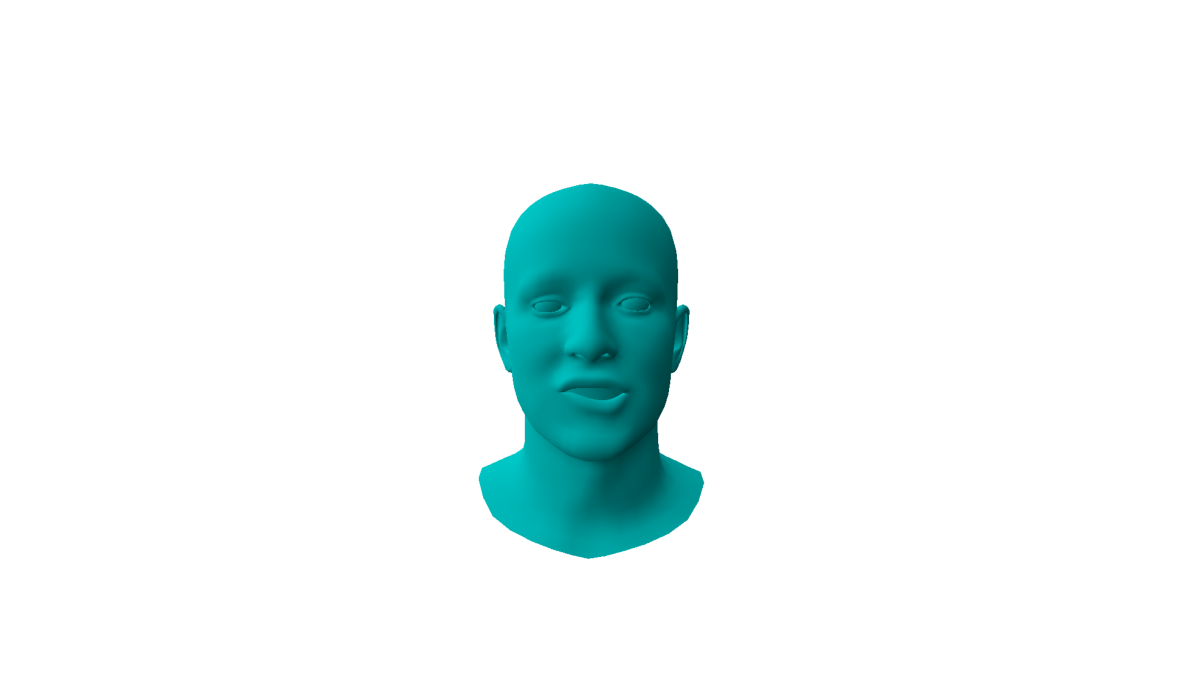

In [30]:
from lib.model.flame.flame import Flame
import torch
from lib.data.loader import load_intrinsics
from lib.rasterizer import Rasterizer
from lib.renderer.renderer import Renderer
from lib.renderer.camera import Camera
from lib.data.synthetic import generate_synthetic_params, generate_params
from lib.utils.visualize import visualize_grid, visualize_params

# settings
data_dir = "/home/borth/GuidedResearch/data/dphm_kinect/christoph_mouthmove"
flame_dir = "/home/borth/GuidedResearch/checkpoints/flame2023_no_jaw"
device = "cuda" if torch.cuda.is_available() else "cpu"

# setup camera, rasterizer and renderer
K = load_intrinsics(data_dir=data_dir, return_tensor="pt")
camera = Camera(K=K, width=1920, height=1080, scale=1)
rasterizer = Rasterizer(width=camera.width, height=camera.height)
renderer = Renderer(rasterizer=rasterizer, camera=camera)

# setup flame optimizer
flame = Flame(
    flame_dir=flame_dir,
    vertices_mask="full",
    expression_params=50,
    shape_params=100,
)

# creaste gt_params
params = generate_synthetic_params(
    flame,
    default=dict(transl=[0.0, 0.0, -0.45]),
    window_size=1,
    sigmas=dict(expression_params=2.0),
    sparsity=0.5,
)
s_out = flame.render(renderer=renderer, params=params)
visualize_params(flame, renderer, params, color=0)

In [3]:
params

{'shape_params': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]], device='cuda:0', grad_fn=<IndexPutBackward0>),
 'scale': tensor([[1.]], device='cuda:0', grad_fn=<AddBackward0>),
 'expression_params': tensor([[-4.9148e-03,  2.5173e-01, -4.7815e-01,  0.0000e+00,  0.0000e+00,
           6.4313e+00,  0.0000e+00,  0.0000e+00,  3.4472e-01,  0.0000e+00,
           4.2962e-01,  0.0000e+00, -8.5795e-01,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  2.3504e+00,  6.6240e+00,
           0.0000e+00,  7.4845e-01,  6.4976e-01,  2.2845e+00, -7.9572e-01,
          -1.1614e+00,

In [ ]:
params["expression_params"]